In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline
 

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
import sklearn
sklearn.__version__

'1.2.1'

In [2]:
# Mengimport data output 'Data Preparation.ipynb'
data = pd.read_csv(r'../Hasil Proses Data/Data Preparation.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73143 entries, 0 to 73142
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   street       73143 non-null  object 
 1   level        73143 non-null  int64  
 2   precip       73143 non-null  float64
 3   Libur        73143 non-null  int64  
 4   day          73143 non-null  object 
 5   ROAD_CLOSED  73143 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 3.3+ MB


In [4]:
data.sample(6)

,street,level,precip,Libur,day,ROAD_CLOSED
45981,Merah Delima 1,0,0.008,0,Thursday,0
4645,Asia Afrika,2,0.012,0,Tuesday,0
73011,Melania,0,2.148,0,Tuesday,0
29682,Jalan Ciwaregu,0,11.943,0,Thursday,0
70742,Kencana Arum 5,0,2.999,0,Sunday,0
12370,Tamblong,3,0.000,0,Monday,0


In [5]:
# Cek apakah masih ada missing value
data.isnull().sum()

street         0
level          0
precip         0
Libur          0
day            0
ROAD_CLOSED    0
dtype: int64

<AxesSubplot: >

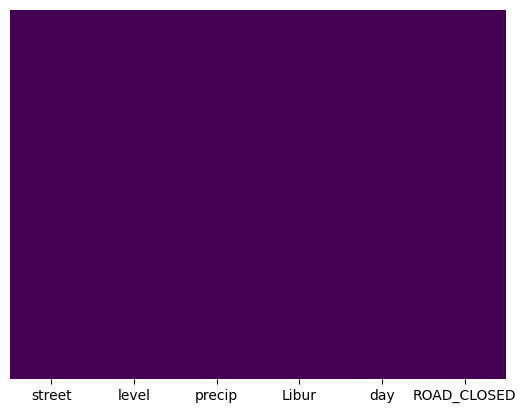

In [6]:
# Cek missing value dengan heatmap
sns.heatmap(data.isnull(),yticklabels=False, cbar=False, cmap='viridis')

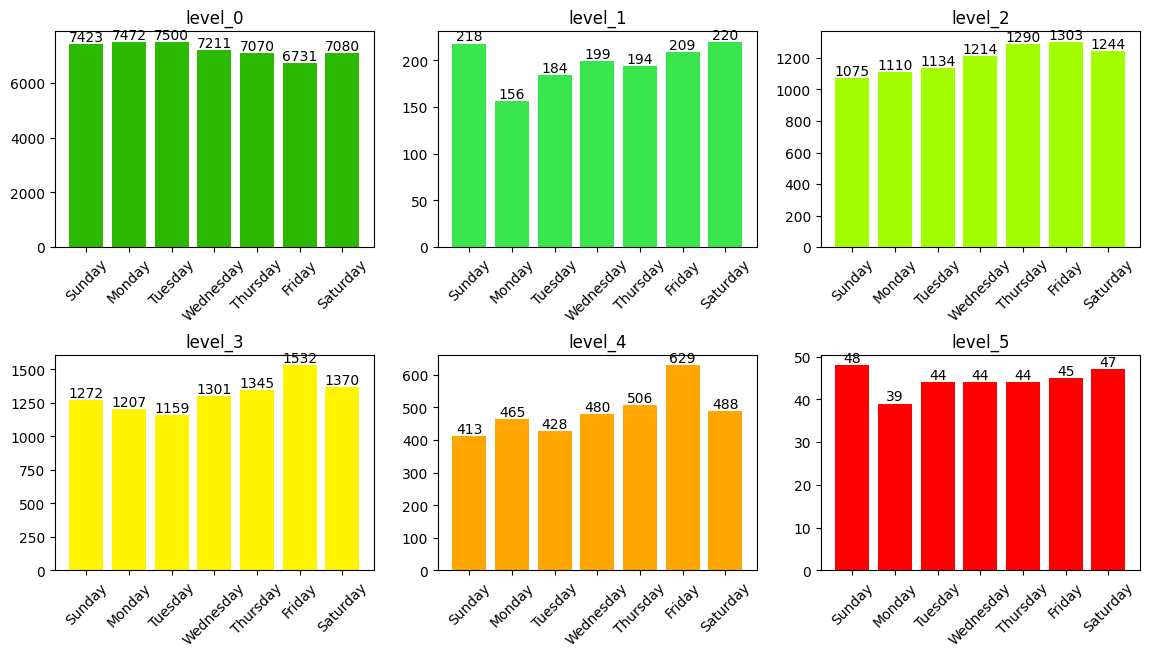

In [7]:
# Membuat grafik persebaran data 'day' pada setiap nilai 'level'
level_list = sorted(list(data['level'].unique()))

name_order = {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday':5, 'Friday':6, 'Saturday':7}
data_bylevel1 = []

for level in level_list:
    level_data = data[data['level'] == level]
    data_name = 'level_' + str(level)

    level_data = level_data.groupby('day')['level'].count()
    level_data = level_data.reset_index()
    level_data.sort_values('day', key=lambda x: x.map(name_order), inplace=True)
    locals()[data_name] = level_data
    data_bylevel1.append(data_name)

fig, ax = plt.subplots(2, 3, figsize=(14, 7))
colors = ['#2cba00', '#38e54d', '#a3ff00', '#fff400', '#ffa700', '#ff0000']
count = 0

for a in range(2):
    for b in range(3):
        data_name = data_bylevel1[count]
        data_forplot = locals()[data_name]
        ax[a,b].bar(data_forplot.day, data_forplot.level, color = colors[count])
        ax[a,b].set_title(data_name)
        ax[a,b].set_xticklabels(ax[a,b].get_xticklabels(), rotation=45)
        for c, d in enumerate(data_forplot.level):
            ax[a,b].annotate(str(d), xy=(c, d), ha='center', va='bottom')
        count += 1


fig.subplots_adjust(hspace=0.5, wspace=0.2 )

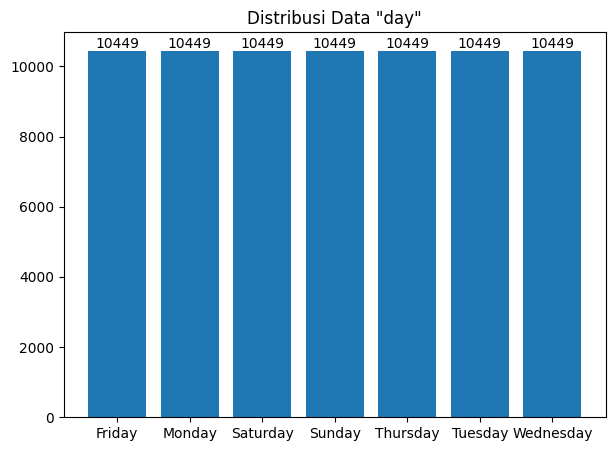

In [8]:
# Membuat grafik jumlah data untuk setiap harinya
plt.figure(figsize=(7,5))

plt.bar(data.groupby('day')['level'].count().index, data.groupby('day')['level'].count().values)
plt.title('Distribusi Data "day"')
for c, d in enumerate(data.groupby('day')['level'].count().values):
    plt.annotate(str(d), xy=(c, d), ha='center', va='bottom')

In [9]:
# Nilai-nilai statistika pada data 'precip
data['precip'].describe()

count    73143.000000
mean         7.179730
std         25.947377
min          0.000000
25%          0.100000
50%          0.700000
75%          3.500000
max        198.896000
Name: precip, dtype: float64

<AxesSubplot: xlabel='precip'>

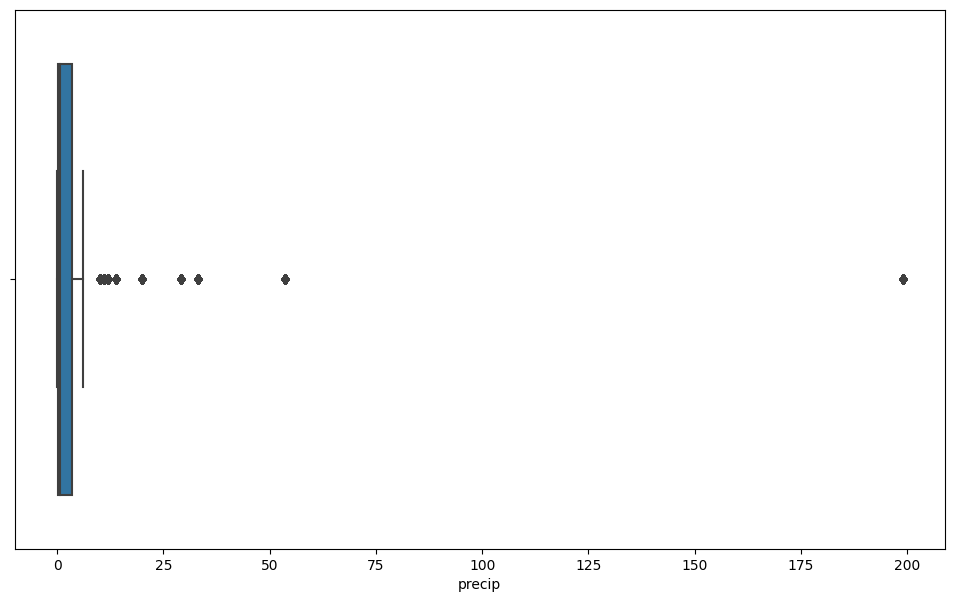

In [10]:
# Persebaran data 'precip'
plt.figure(figsize=(12,7))
sns.boxplot(x=data['precip'])

In [11]:
level_counts = data['level'].value_counts()
level_counts_percentage = data['level'].value_counts(normalize=True).round(3)

<Figure size 1200x700 with 0 Axes>

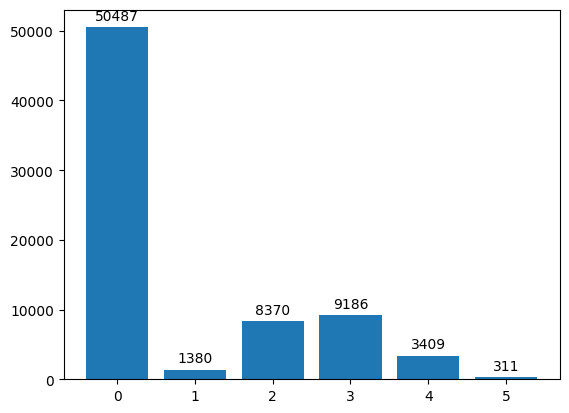

In [12]:
# Membuat barchart perbandingan jumlah data pada setiap label
plt.figure(figsize=(12,7))

fig, ax = plt.subplots()
rects = ax.bar(level_counts.index, level_counts.values)

for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

<Figure size 1200x700 with 0 Axes>

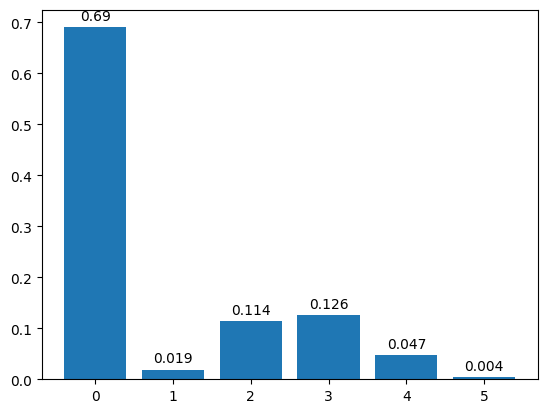

In [13]:
# Membuat barchart persentase data dari setiap label terhadap
# data keseluruhan
plt.figure(figsize=(12,7))

fig, ax = plt.subplots()
rects = ax.bar(level_counts_percentage.index, level_counts_percentage.values)

for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

## Encode Categorical Data

In [14]:
# Encode kolom 'day' menggunakan One Hot Encodeer
day_oh_encode = OneHotEncoder(sparse_output=False)
df_day = day_oh_encode.fit_transform(data[['day']])
df_day = pd.DataFrame(df_day)
df_day.columns = day_oh_encode.get_feature_names_out(['day'])

In [15]:
df_day.sample(6)

,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
30602,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9608,0.0,0.0,0.0,1.0,0.0,0.0,0.0
53651,0.0,0.0,0.0,1.0,0.0,0.0,0.0
21311,0.0,0.0,0.0,0.0,1.0,0.0,0.0
37955,0.0,1.0,0.0,0.0,0.0,0.0,0.0
27076,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [16]:
data.drop('day', axis=1, inplace=True)
data = pd.concat([data, df_day], axis=1)
data.sample(6)

,street,level,precip,Libur,ROAD_CLOSED,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
7235,Lengkong Kecil,3,0.300,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3200,Jalan Raya Dayeuhkolot,2,4.068,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
66579,Hariangbanga,0,0.994,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7068,Cikapayang,3,0.300,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
38754,Cihaur Kuku,0,0.200,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25447,Jalan Ma Eja,0,0.300,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Pada proses encode kolom 'street' akan dibagi menjadi dua, satu data akan menggunakan BinaryEncoder, dan satu data lainnya akan berupa OneHotEncoder

In [17]:
# Encode kolom 'street' dengan BinaryEncoder
street_binary_encode = ce.BinaryEncoder()
street_binary = street_binary_encode.fit_transform(data['street'])

street_binary.sample(6)

KeyboardInterrupt: 

In [ ]:
data_binaryencode = pd.concat([data, street_binary], axis=1)
data_binaryencode.head(6)

,street,level,precip,Libur,ROAD_CLOSED,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,...,street_1,street_2,street_3,street_4,street_5,street_6,street_7,street_8,street_9,street_10
0,Abdul Rahman Saleh,2,1.134,0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,Akses Tol Pasteur,3,1.134,0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,Alkateri,2,1.134,0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
3,Alun-alun Timur,3,1.134,0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,Anggrek,4,1.134,0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
5,Antapani,2,1.134,0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,1,0


In [ ]:
# Encode kolom 'street' dengan OneHotEncoder
street_oh_encode = OneHotEncoder(sparse_output=False)
df_street = day_oh_encode.fit_transform(data[['street']])
df_street = pd.DataFrame(df_street)
df_street.columns = day_oh_encode.get_feature_names_out(['street'])

In [ ]:
df_street

,street_Abadi 1,street_Abadi Raya,street_Abadi Regency,street_Abdul Halim,street_Abdul Rahman Saleh,street_Adi Flora Raya,street_Adiyaksa - Terusan Buah Batu,street_Aeromodeling,street_Aeromodeling 4,street_Ajudan Jenderal,...,street_Wastukencana,street_Wayang,street_Westhoff,street_Wijayakusumah,street_Windu,street_Wira Angun-angun,street_Yakin,street_Yuda,street_Yudawastu Pramuka 4,street_de' Elgran Residence
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_oh_encode = pd.concat([data, df_street], axis=1)
data_oh_encode.sample(6)

,street,level,precip,Libur,ROAD_CLOSED,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,...,street_Wastukencana,street_Wayang,street_Westhoff,street_Wijayakusumah,street_Windu,street_Wira Angun-angun,street_Yakin,street_Yuda,street_Yudawastu Pramuka 4,street_de' Elgran Residence
47868,De' Marrakesh,0,0.631,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62898,Sindangsari,0,0.200,0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30346,Budi Luhur,0,4.068,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67673,Pasir Subur,0,3.500,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63736,Terjun Tandom,0,0.995,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65237,Silverstone,0,0.010,0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Menghapus kolom 'street' pada kedua data
# Kolom 'street' sudah di encode sehingga tidak dibutuhkan
data_oh_encode.drop('street', axis=1, inplace=True)
data_binaryencode.drop('street', axis=1, inplace=True)

In [ ]:
# Memisahkan features dan label
x_oh_encode = data_oh_encode.drop('level', axis=1)
y_oh_encode = data_oh_encode.level

# Split data train dan test dengan perbandingan 7:3
x_train_oh, x_test_oh, y_train_oh, y_test_oh =  train_test_split(x_oh_encode, y_oh_encode, test_size = 0.3, random_state = 123)

# Melakukan hal yang sama terhadap data_binaryencode
x_binaryencode = data_binaryencode.drop('level', axis=1)
y_binaryencode = data_binaryencode.level

x_train_be, x_test_be, y_train_be, y_test_be =  train_test_split(x_binaryencode, y_binaryencode, test_size = 0.3, random_state = 123)

In [ ]:
# Karena menggunakan random_state yang sama
# maka kedua data mempunyai hasil split yang sama
y_test_be.equals(y_test_oh)

True

<Figure size 1200x700 with 0 Axes>

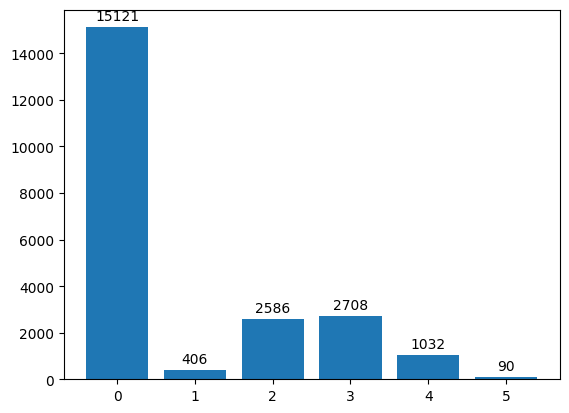

In [ ]:
y_test_counts = y_test_oh.value_counts()

plt.figure(figsize=(12,7))

fig, ax = plt.subplots()
rects = ax.bar(y_test_counts.index, y_test_counts.values)

for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

<Figure size 1200x700 with 0 Axes>

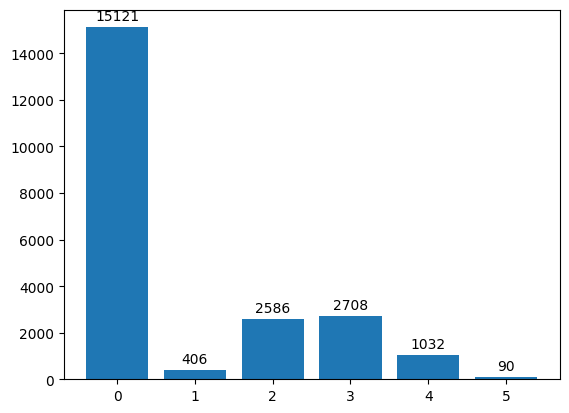

In [ ]:
y_test_counts = y_test_be.value_counts()

plt.figure(figsize=(12,7))

fig, ax = plt.subplots()
rects = ax.bar(y_test_counts.index, y_test_counts.values)

for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

<Figure size 1200x700 with 0 Axes>

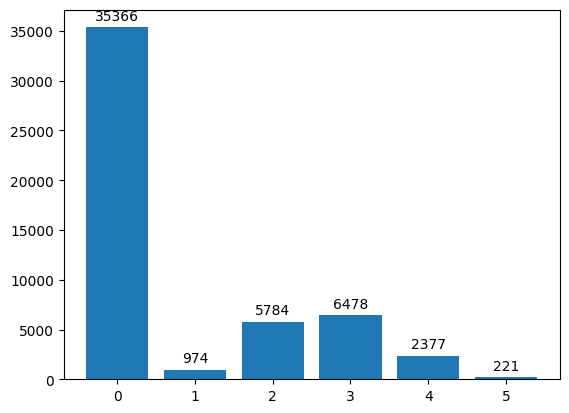

In [ ]:
y_train_counts = y_train_be.value_counts()

plt.figure(figsize=(12,7))

fig, ax = plt.subplots()
rects = ax.bar(y_train_counts.index, y_train_counts.values)

for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

## Data Scaling

Pada proses scaling akan dibagi menjadi dua, sehingga akan terdapat data dengan MinMaxScaler dan StandardScaler. 

### MinMaxScaler

In [ ]:
# Scaling dengan MinMaxScaler
scaler_for_binary = MinMaxScaler()
x_scaled_minmax_be = scaler_for_binary.fit_transform(x_train_be)
x_train_minmax_be = pd.DataFrame(x_scaled_minmax_be, columns=x_train_be.columns)

scaler_for_oh = MinMaxScaler()
x_scaled_minmax_oh = scaler_for_oh.fit_transform(x_train_oh)
x_train_minmax_oh = pd.DataFrame(x_scaled_minmax_oh, columns=x_train_oh.columns)

In [ ]:
x_train_minmax_be.head(2)

,precip,Libur,ROAD_CLOSED,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,...,street_1,street_2,street_3,street_4,street_5,street_6,street_7,street_8,street_9,street_10
0,0.000503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.001508,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
x_train_minmax_oh.head(2)

,precip,Libur,ROAD_CLOSED,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,...,street_Wastukencana,street_Wayang,street_Westhoff,street_Wijayakusumah,street_Windu,street_Wira Angun-angun,street_Yakin,street_Yuda,street_Yudawastu Pramuka 4,street_de' Elgran Residence
0,0.000503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.001508,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Saat scaling index akan reset,
# Reset index untuk y_train untuk menghindari error saat concat data
y_train_be = y_train_be.reset_index()
y_train_be = y_train_be.drop('index', axis=1)
y_train_be.head()

y_train_oh = y_train_oh.reset_index()
y_train_oh = y_train_oh.drop('index', axis=1)
y_train_oh.head()

,level
0,4
1,4
2,0
3,4
4,2


In [ ]:
# Scaling data test menggunakan scaler dari data train
x_test_scaled_minmax_be = scaler_for_binary.transform(x_test_be)
x_test_minmax_be = pd.DataFrame(x_test_scaled_minmax_be, columns=x_test_be.columns)

x_test_scaled_minmax_oh = scaler_for_oh.transform(x_test_oh)
x_test_minmax_oh = pd.DataFrame(x_test_scaled_minmax_oh, columns=x_test_oh.columns)

In [ ]:
x_test_minmax_be.head(3)

,precip,Libur,ROAD_CLOSED,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,...,street_1,street_2,street_3,street_4,street_5,street_6,street_7,street_8,street_9,street_10
0,0.003519,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,0.030755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
2,0.000503,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0


In [ ]:
x_test_minmax_oh.head(3)

,precip,Libur,ROAD_CLOSED,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,...,street_Wastukencana,street_Wayang,street_Westhoff,street_Wijayakusumah,street_Windu,street_Wira Angun-angun,street_Yakin,street_Yuda,street_Yudawastu Pramuka 4,street_de' Elgran Residence
0,0.003519,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.030755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000503,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Saat scaling index akan reset,
# Reset index untuk y_test untuk menghindari error saat concat data
y_test_be = y_test_be.reset_index()
y_test_be = y_test_be.drop('index', axis=1)
y_test_be.head()

y_test_oh = y_test_oh.reset_index()
y_test_oh = y_test_oh.drop('index', axis=1)
y_test_oh.head()

,level
0,0
1,0
2,2
3,0
4,2


### StandardScaler

In [ ]:
# Scaling dengan StandardScaler
standardscaler_for_binary = StandardScaler()
x_scaled_standard_be = standardscaler_for_binary.fit_transform(x_train_be)
x_train_standard_be = pd.DataFrame(x_scaled_standard_be, columns=x_train_be.columns)

standardscaler_for_oh = StandardScaler()
x_scaled_standard_oh = standardscaler_for_oh.fit_transform(x_train_oh)
x_train_standard_oh = pd.DataFrame(x_scaled_standard_oh, columns=x_train_oh.columns)


In [ ]:
x_train_standard_be.head(2)

,precip,Libur,ROAD_CLOSED,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,...,street_1,street_2,street_3,street_4,street_5,street_6,street_7,street_8,street_9,street_10
0,-0.272347,-0.223265,-0.066881,-0.40902,-0.405794,-0.40954,-0.409085,-0.407522,-0.408532,2.449546,...,-0.890382,-0.886265,1.105498,1.007528,-0.995596,-0.99311,1.004149,-0.998166,-1.003287,-1.003757
1,-0.264581,-0.223265,-0.066881,-0.40902,2.464305,-0.40954,-0.409085,-0.407522,-0.408532,-0.408239,...,-0.890382,-0.886265,1.105498,1.007528,1.004424,-0.99311,1.004149,-0.998166,-1.003287,-1.003757


In [ ]:
x_train_standard_oh.head(2)

,precip,Libur,ROAD_CLOSED,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,...,street_Wastukencana,street_Wayang,street_Westhoff,street_Wijayakusumah,street_Windu,street_Wira Angun-angun,street_Yakin,street_Yuda,street_Yudawastu Pramuka 4,street_de' Elgran Residence
0,-0.272347,-0.223265,-0.066881,-0.40902,-0.405794,-0.40954,-0.409085,-0.407522,-0.408532,2.449546,...,-0.029328,-0.031885,-0.031577,-0.028653,-0.029659,-0.029659,-0.028309,-0.030633,-0.02761,-0.030633
1,-0.264581,-0.223265,-0.066881,-0.40902,2.464305,-0.40954,-0.409085,-0.407522,-0.408532,-0.408239,...,-0.029328,-0.031885,-0.031577,-0.028653,-0.029659,-0.029659,-0.028309,-0.030633,-0.02761,-0.030633


In [ ]:
# Scaling data test menggunakan scaler dari data train
x_test_scaled_standard_be = standardscaler_for_binary.transform(x_test_be)
x_test_standard_be = pd.DataFrame(x_test_scaled_standard_be, columns=x_test_be.columns)

x_test_scaled_standard_oh = standardscaler_for_oh.transform(x_test_oh)
x_test_standard_oh = pd.DataFrame(x_test_scaled_standard_oh, columns=x_test_oh.columns)

In [ ]:
x_test_standard_be.head(3)

,precip,Libur,ROAD_CLOSED,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,...,street_1,street_2,street_3,street_4,street_5,street_6,street_7,street_8,street_9,street_10
0,-0.249049,4.478983,-0.066881,-0.40902,-0.405794,-0.40954,2.444479,-0.407522,-0.408532,-0.408239,...,-0.890382,1.128331,-0.90457,-0.992528,-0.995596,-0.99311,1.004149,1.001838,-1.003287,0.996257
1,-0.038710,-0.223265,-0.066881,-0.40902,-0.405794,-0.40954,-0.409085,-0.407522,-0.408532,2.449546,...,1.123114,1.128331,-0.90457,-0.992528,1.004424,-0.99311,-0.995868,1.001838,0.996724,0.996257
2,-0.272347,-0.223265,-0.066881,-0.40902,-0.405794,-0.40954,-0.409085,2.453853,-0.408532,-0.408239,...,-0.890382,1.128331,-0.90457,1.007528,-0.995596,-0.99311,1.004149,1.001838,-1.003287,0.996257


In [ ]:
x_test_standard_oh.head(3)

,precip,Libur,ROAD_CLOSED,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,...,street_Wastukencana,street_Wayang,street_Westhoff,street_Wijayakusumah,street_Windu,street_Wira Angun-angun,street_Yakin,street_Yuda,street_Yudawastu Pramuka 4,street_de' Elgran Residence
0,-0.249049,4.478983,-0.066881,-0.40902,-0.405794,-0.40954,2.444479,-0.407522,-0.408532,-0.408239,...,-0.029328,-0.031885,-0.031577,-0.028653,-0.029659,-0.029659,-0.028309,-0.030633,-0.02761,-0.030633
1,-0.038710,-0.223265,-0.066881,-0.40902,-0.405794,-0.40954,-0.409085,-0.407522,-0.408532,2.449546,...,-0.029328,-0.031885,-0.031577,-0.028653,-0.029659,-0.029659,-0.028309,-0.030633,-0.02761,-0.030633
2,-0.272347,-0.223265,-0.066881,-0.40902,-0.405794,-0.40954,-0.409085,2.453853,-0.408532,-0.408239,...,-0.029328,-0.031885,-0.031577,-0.028653,-0.029659,-0.029659,-0.028309,-0.030633,-0.02761,-0.030633


## Handling Data Imbalance 

Untuk mengatasi data imbalance, akan menggunakan 2 cara kombinasi. Yaitu SMOTE-Tomek dan SMOTE-ENN

### SMOTE-TOMEK

In [ ]:
# I'll use combination of SMOTE for Oversampler and Tomek-Link as Undersampler

# Define the SMOTE-Tomek resampler
smt_minmax_be = SMOTETomek(random_state=42)
smt_minmax_oh = SMOTETomek(random_state=42)
smt_standard_be = SMOTETomek(random_state=42)
smt_standard_oh = SMOTETomek(random_state=42)

# Apply the resampler to the dataset
X_smt_minmax_be, y_smt_minmax_be = smt_minmax_be.fit_resample(x_train_minmax_be, y_train_be['level'])
X_smt_minmax_oh, y_smt_minmax_oh = smt_minmax_oh.fit_resample(x_train_minmax_oh, y_train_oh['level'])
X_smt_standard_be, y_smt_standard_be = smt_standard_be.fit_resample(x_train_standard_be, y_train_be['level'])
X_smt_standard_oh, y_smt_standard_oh = smt_standard_oh.fit_resample(x_train_standard_be, y_train_be['level'])

In [ ]:
X_smt_minmax_be.head(3)

,precip,Libur,ROAD_CLOSED,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,...,street_1,street_2,street_3,street_4,street_5,street_6,street_7,street_8,street_9,street_10
0,0.000503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.001508,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.000503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,0.000277,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
4,0.005003,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
5,0.030755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
X_smt_minmax_oh.head(3)

In [ ]:
X_smt_standard_be.head(3)

In [ ]:
X_smt_standard_oh.head(3)

<Figure size 1200x700 with 0 Axes>

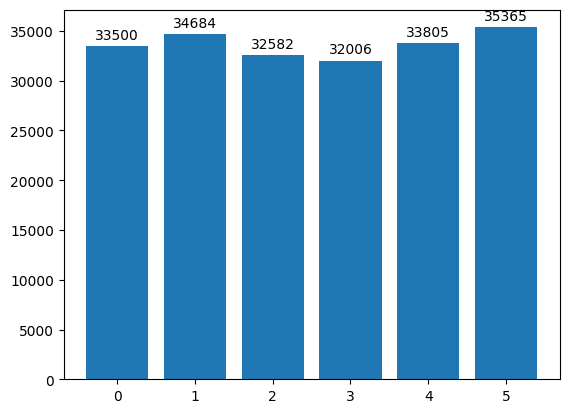

In [ ]:
y_resampled_counts = y_smt_minmax_be.value_counts()

plt.figure(figsize=(12,7))

fig, ax = plt.subplots()
rects = ax.bar(y_resampled_counts.index, y_resampled_counts.values)

for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

In [ ]:
y_resampled_counts = y_smt_minmax_oh.value_counts()

plt.figure(figsize=(12,7))

fig, ax = plt.subplots()
rects = ax.bar(y_resampled_counts.index, y_resampled_counts.values)

for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

In [ ]:
y_resampled_counts = y_smt_standard_be.value_counts()

plt.figure(figsize=(12,7))

fig, ax = plt.subplots()
rects = ax.bar(y_resampled_counts.index, y_resampled_counts.values)

for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

In [ ]:
y_resampled_counts = y_smt_standard_oh.value_counts()

plt.figure(figsize=(12,7))

fig, ax = plt.subplots()
rects = ax.bar(y_resampled_counts.index, y_resampled_counts.values)

for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

### SMOTE-ENN

In [ ]:
# Define the SMOTE-Tomek resampler
sme_minmax_be = SMOTEENN(random_state=42)
sme_minmax_oh = SMOTEENN(random_state=42)
sme_standard_be = SMOTEENN(random_state=42)
sme_standard_oh = SMOTEENN(random_state=42)

# Apply the resampler to the dataset
X_sme_minmax_be, y_sme_minmax_be = sme_minmax_be.fit_resample(x_train_minmax_be, y_train_be['level'])
X_sme_minmax_oh, y_sme_minmax_oh = sme_minmax_oh.fit_resample(x_train_minmax_oh, y_train_oh['level'])
X_sme_standard_be, y_sme_standard_be = sme_standard_be.fit_resample(x_train_standard_be, y_train_be['level'])
X_sme_standard_oh, y_sme_standard_oh = sme_standard_oh.fit_resample(x_train_standard_be, y_train_be['level'])


In [ ]:
X_sme_minmax_be.head(3)

,precip,Libur,ROAD_CLOSED,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,...,street_1,street_2,street_3,street_4,street_5,street_6,street_7,street_8,street_9,street_10
0,0.030755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.030755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.003519,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.000000,0.000000,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,0.004002,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.000000,0.000000,0.0,0.0,1.0,1.0,0.0,1.0,1.0
4,0.000025,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.000000,1.000000,1.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163045,0.001817,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,1.000000,1.0,1.0,0.0,1.0,0.0,1.0,0.0
163046,0.002033,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,1.000000,1.0,1.0,0.0,1.0,0.0,1.0,0.0
163047,0.008345,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.143438,0.856562,1.0,0.0,1.0,0.0,0.0,1.0,1.0
163048,0.046027,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,1.000000,1.0,0.0,1.0,0.0,0.0,1.0,1.0


In [ ]:
X_sme_minmax_oh.head(3)

In [ ]:
X_sme_standard_be.head(3)

In [ ]:
X_sme_standard_oh.head(3)

<Figure size 1200x700 with 0 Axes>

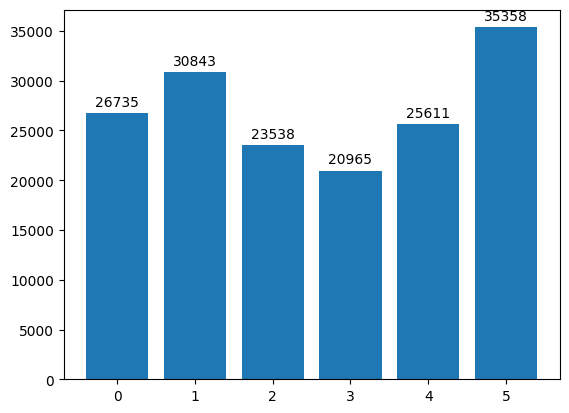

In [ ]:
y_resampled_counts = y_sme_minmax_be.value_counts()

plt.figure(figsize=(12,7))

fig, ax = plt.subplots()
rects = ax.bar(y_resampled_counts.index, y_resampled_counts.values)

for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

In [ ]:
y_resampled_counts = y_sme_minmax_oh.value_counts()

plt.figure(figsize=(12,7))

fig, ax = plt.subplots()
rects = ax.bar(y_resampled_counts.index, y_resampled_counts.values)

for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

In [ ]:
y_resampled_counts = y_sme_standard_be.value_counts()

plt.figure(figsize=(12,7))

fig, ax = plt.subplots()
rects = ax.bar(y_resampled_counts.index, y_resampled_counts.values)

for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

In [ ]:
y_resampled_counts = y_sme_standard_oh.value_counts()

plt.figure(figsize=(12,7))

fig, ax = plt.subplots()
rects = ax.bar(y_resampled_counts.index, y_resampled_counts.values)

for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

## Output Data

In [ ]:
data_smt_minmax_be = X_smt_minmax_be
data_smt_minmax_be['level'] = y_smt_minmax_be
data_smt_minmax_be.head(3)

,precip,Libur,ROAD_CLOSED,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,...,street_2,street_3,street_4,street_5,street_6,street_7,street_8,street_9,street_10,level
0,0.000503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4
1,0.001508,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,4
2,0.000503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0
3,0.000277,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,4
4,0.005003,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2
5,0.030755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [ ]:
data_smt_minmax_oh = X_smt_minmax_oh
data_smt_minmax_oh['level'] = y_smt_minmax_oh
data_smt_minmax_oh.head(3)

In [ ]:
data_smt_standard_be = X_smt_standard_be
data_smt_standard_be['level'] = y_smt_standard_be
data_smt_standard_be.head(3)

In [ ]:
data_smt_standard_oh = X_smt_standard_oh
data_smt_standard_oh['level'] = y_smt_standard_oh
data_smt_standard_oh.head(3)

In [ ]:
data_sme_minmax_be = X_sme_minmax_be
data_sme_minmax_be['level'] = y_sme_minmax_be
data_sme_minmax_be.head(3)

,precip,Libur,ROAD_CLOSED,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,...,street_2,street_3,street_4,street_5,street_6,street_7,street_8,street_9,street_10,level
152295,0.002984,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.000000,1.0,1.0,0.0,1.0,0.000000,1.0,0.0,5
3863,0.001006,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,1.0,1.000000,1.0,1.0,0
122819,0.013553,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.000000,0.0,1.0,1.0,1.0,0.000000,0.0,1.0,4
30460,0.021722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.368842,0.0,1.0,1.0,0.0,0.368842,0.0,1.0,1
60062,0.004998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.000000,1.0,0.0,0.0,0.0,1.000000,0.0,1.0,2
160701,0.007988,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.000000,0.0,1.0,1.0,0.0,1.000000,1.0,1.0,5


In [ ]:
data_sme_minmax_oh = X_sme_minmax_oh
data_sme_minmax_oh['level'] = y_sme_minmax_oh
data_sme_minmax_oh.head(3)

In [ ]:
data_sme_standard_be = X_sme_standard_be
data_sme_standard_be['level'] = y_sme_standard_be
data_sme_standard_be.head(3)

In [ ]:
data_sme_standard_oh = X_sme_standard_oh
data_sme_standard_oh['level'] = y_sme_standard_oh
data_sme_standard_oh.head(3)

In [ ]:
data_test_minmax_be = x_test_minmax_be
data_test_minmax_be = pd.concat([data_test_minmax_be, y_test_be], axis=1)
data_test_minmax_be.sample(3)

In [ ]:
data_test_minmax_oh = x_test_minmax_oh
data_test_minmax_oh = pd.concat([data_test_minmax_oh, y_test_oh], axis=1)
data_test_minmax_oh.sample(3)

In [ ]:
data_test_standard_be = x_test_standard_be
data_test_standard_be = pd.concat([data_test_standard_be, y_test_be], axis=1)
data_test_standard_be.sample(3)

In [ ]:
data_test_standard_oh = x_test_standard_oh
data_test_standard_oh = pd.concat([data_test_standard_oh, y_test_oh], axis=1)
data_test_standard_oh.sample(3)

In [ ]:
data_smt_minmax_be.to_csv('..\Hasil Proses Data\data_smt_minmax_be.csv', index=False)
data_smt_minmax_oh.to_csv('..\Hasil Proses Data\data_smt_minmax_oh.csv', index=False)
data_smt_standard_be.to_csv('..\Hasil Proses Data\data_smt_standard_be.csv', index=False)
data_smt_standard_oh.to_csv('..\Hasil Proses Data\data_smt_standard_oh.csv', index=False)
data_sme_minmax_be.to_csv('..\Hasil Proses Data\data_sme_minmax_be.csv', index=False)
data_sme_minmax_oh.to_csv('..\Hasil Proses Data\data_sme_minmax_oh.csv', index=False)
data_sme_standard_be.to_csv('..\Hasil Proses Data\data_sme_standard_be.csv', index=False)
data_sme_standard_oh.to_csv('..\Hasil Proses Data\data_sme_standard_oh.csv', index=False)
data_test_minmax_be.to_csv('..\Hasil Proses Data\data_test_minmax_be.csv', index=False)
data_test_minmax_oh.to_csv('..\Hasil Proses Data\data_test_minmax_oh.csv', index=False)
data_test_standard_be.to_csv('..\Hasil Proses Data\data_test_standard_be.csv', index=False)
data_test_standard_oh.to_csv('..\Hasil Proses Data\data_test_standard_oh.csv', index=False)

In [5]:
pip install pipreqs

Note: you may need to restart the kernel to use updated packages.Collecting pipreqs
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached requests-2.28.2-py3-none-any.whl (62 kB)
  Using cached certifi-2022.12.7-py3-none-any.whl (155 kB)
  Using cached urllib3-1.26.14-py2.py3-none-any.whl (140 kB)
  Using cached idna-3.4-py3-none-any.whl (61 kB)
  Using cached charset_normalizer-3.0.1-cp310-cp310-win_amd64.whl (96 kB)
  Running setup.py install for docopt: started
  Running setup.py install for docopt: finished with status 'done'



  DEPRECATION: docopt is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 105-106: malformed \N character escape (2772094005.py, line 1)